In [0]:
!pip install fire

     |████████████████████████████████| 81kB 3.2MB/s 
  Created wheel for fire: filename=fire-0.2.1-py2.py3-none-any.whl size=103527 sha256=793e15d10caa83222c8872ebcc494dc05d62ee9a8d68ea39f049607a1c6cfb1d
  Stored in directory: /root/.cache/pip/wheels/31/9c/c0/07b6dc7faf1844bb4688f46b569efe6cafaa2179c95db821da
Successfully built fire


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My\ Drive/"
base_dir = root_dir + 'fastai-v3/les8'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
cd /content/gdrive/My\ Drive/fastai-v3/les8

/content/gdrive/My Drive/fastai-v3/les8


In [0]:
pwd

'/content/gdrive/My Drive/fastai-v3/les8'

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#export
from exp.nb_06 import *


ConvNet

Let's get the data and training interface from where we left in the last notebook.


In [0]:
x_train,y_train,x_valid,y_valid = get_data()

x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train), Dataset(x_valid, y_valid)

nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
mnist_view = view_tfm(1,28,28)
cbfs = [Recorder, partial(AvgStatsCallback,accuracy), CudaCallback, partial(BatchTransformXCallback, mnist_view)]

In [0]:
nfs = [8,16,32,64,64]

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [0]:
%time run.fit(2, learn)

train: [1.4120246875, tensor(0.5456, device='cuda:0')]
valid: [0.3750831787109375, tensor(0.8807, device='cuda:0')]
train: [0.2170394921875, tensor(0.9323, device='cuda:0')]
valid: [0.1358891845703125, tensor(0.9608, device='cuda:0')]
CPU times: user 4.88 s, sys: 1.91 s, total: 6.8 s
Wall time: 10.5 s



Batchnorm
Custom

Let's start by building our own BatchNorm layer from scratch.


In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

We can then use it in training and see how it helps keep the activations means to 0 and the std to 1.

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.25542337890625, tensor(0.9212, device='cuda:0')]
valid: [0.18606011962890626, tensor(0.9415, device='cuda:0')]


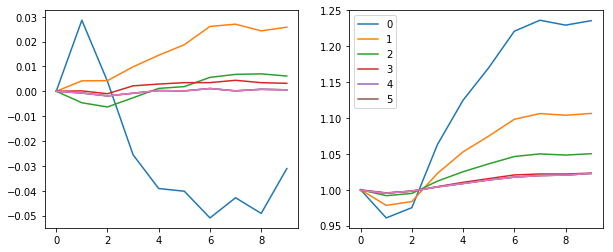

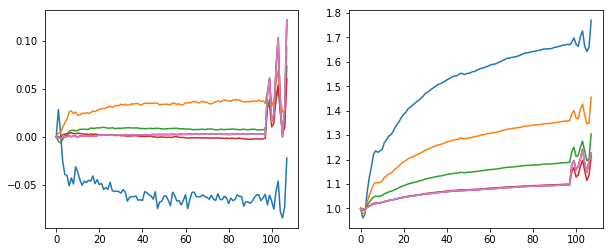

In [0]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [0.26678427734375, tensor(0.9168, device='cuda:0')]
valid: [0.1331802734375, tensor(0.9570, device='cuda:0')]
train: [0.089204091796875, tensor(0.9722, device='cuda:0')]
valid: [0.12096942138671875, tensor(0.9615, device='cuda:0')]
train: [0.0631670361328125, tensor(0.9799, device='cuda:0')]
valid: [0.10577437744140625, tensor(0.9682, device='cuda:0')]
CPU times: user 4.69 s, sys: 1.53 s, total: 6.22 s
Wall time: 6.24 s


Builtin batchnorm

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [0.2561440234375, tensor(0.9234, device='cuda:0')]
valid: [0.12283409423828125, tensor(0.9641, device='cuda:0')]
train: [0.0753083154296875, tensor(0.9767, device='cuda:0')]
valid: [0.086900732421875, tensor(0.9723, device='cuda:0')]
train: [0.054573818359375, tensor(0.9829, device='cuda:0')]
valid: [0.05533900146484375, tensor(0.9827, device='cuda:0')]
CPU times: user 4.37 s, sys: 1.55 s, total: 5.92 s
Wall time: 5.95 s



With scheduler

Now let's add the usual warm-up/annealing.


In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [0]:
run.fit(8, learn)

train: [0.31784291015625, tensor(0.9073, device='cuda:0')]
valid: [0.17389613037109375, tensor(0.9437, device='cuda:0')]
train: [0.096655654296875, tensor(0.9707, device='cuda:0')]
valid: [0.09641539916992188, tensor(0.9702, device='cuda:0')]
train: [0.0683004541015625, tensor(0.9774, device='cuda:0')]
valid: [0.0747609130859375, tensor(0.9771, device='cuda:0')]
train: [0.0429230322265625, tensor(0.9863, device='cuda:0')]
valid: [0.06158056640625, tensor(0.9806, device='cuda:0')]
train: [0.02910196533203125, tensor(0.9906, device='cuda:0')]
valid: [0.05078104248046875, tensor(0.9850, device='cuda:0')]
train: [0.01780181640625, tensor(0.9948, device='cuda:0')]
valid: [0.04820652160644531, tensor(0.9854, device='cuda:0')]
train: [0.0109301123046875, tensor(0.9974, device='cuda:0')]
valid: [0.040732470703125, tensor(0.9866, device='cuda:0')]
train: [0.007570065307617188, tensor(0.9987, device='cuda:0')]
valid: [0.0410082275390625, tensor(0.9874, device='cuda:0')]



More norms
Layer norm

From the paper: "batch normalization cannot be applied to online learning tasks or to extremely large distributed models where the minibatches have to be small".

General equation for a norm layer with learnable affine:
$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

The difference with BatchNorm is

    we don't keep a moving average
    we don't average over the batches dimension but over the hidden dimension, so it's independent of the batch size



In [0]:
class LayerNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add  = nn.Parameter(tensor(0.))

    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var ((1,2,3), keepdim=True)
        x = (x-m) / ((v+self.eps).sqrt())
        return x*self.mult + self.add

In [0]:
def conv_ln(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(LayerNorm())
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.8, conv_ln, cbs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [nan, tensor(0.1217, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.58 s, sys: 1.73 s, total: 7.31 s
Wall time: 7.34 s




Thought experiment: can this distinguish foggy days from sunny days (assuming you're using it before the first conv)?
Instance norm

From the paper:

The key difference between contrast and batch normalization is that the latter applies the normalization to a whole batch of images instead for single ones:
$$\label{eq:bnorm} y_{tijk} = \frac{x_{tijk} - \mu_{i}}{\sqrt{\sigma_i^2 + \epsilon}}, \quad \mu_i = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H x_{tilm}, \quad \sigma_i^2 = \frac{1}{HWT}\sum_{t=1}^T\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_i)^2. $$

In order to combine the effects of instance-specific normalization and batch normalization, we propose to replace the latter by the instance normalization (also known as contrast normalization) layer:
$$\label{eq:inorm} y_{tijk} = \frac{x_{tijk} - \mu_{ti}}{\sqrt{\sigma_{ti}^2 + \epsilon}}, \quad \mu_{ti} = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H x_{tilm}, \quad \sigma_{ti}^2 = \frac{1}{HW}\sum_{l=1}^W \sum_{m=1}^H (x_{tilm} - mu_{ti})^2. $$


In [0]:
class InstanceNorm(nn.Module):
    __constants__ = ['eps']
    def __init__(self, nf, eps=1e-0):
        super().__init__()
        self.eps = eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))

    def forward(self, x):
        m = x.mean((2,3), keepdim=True)
        v = x.var ((2,3), keepdim=True)
        res = (x-m) / ((v+self.eps).sqrt())
        return res*self.mults + self.adds

In [0]:
def conv_in(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=True),
              GeneralRelu(**kwargs)]
    if bn: layers.append(InstanceNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.1, conv_in, cbs=cbfs)

In [0]:
%time run.fit(3, learn)

train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
train: [nan, tensor(0.0986, device='cuda:0')]
valid: [nan, tensor(0.0991, device='cuda:0')]
CPU times: user 5.75 s, sys: 1.86 s, total: 7.61 s
Wall time: 7.64 s




Question: why can't this classify anything?

Lost in all those norms? The authors from the group norm paper have you covered:


Group norm

Jump_to lesson 10 video

From the PyTorch docs:

GroupNorm(num_groups, num_channels, eps=1e-5, affine=True)

The input channels are separated into num_groups groups, each containing num_channels / num_groups channels. The mean and standard-deviation are calculated separately over the each group. $\gamma$ and $\beta$ are learnable per-channel affine transform parameter vectorss of size num_channels if affine is True.

This layer uses statistics computed from input data in both training and evaluation modes.

Args:

    num_groups (int): number of groups to separate the channels into
    num_channels (int): number of channels expected in input
    eps: a value added to the denominator for numerical stability. Default: 1e-5
    affine: a boolean value that when set to True, this module has learnable per-channel affine parameters initialized to ones (for weights) and zeros (for biases). Default: True.

Shape:

    Input: (N, num_channels, *)
    Output: (N, num_channels, *) (same shape as input)

Examples::

>>> input = torch.randn(20, 6, 10, 10)
>>> # Separate 6 channels into 3 groups
>>> m = nn.GroupNorm(3, 6)
>>> # Separate 6 channels into 6 groups (equivalent with InstanceNorm)
>>> m = nn.GroupNorm(6, 6)
>>> # Put all 6 channels into a single group (equivalent with LayerNorm)
>>> m = nn.GroupNorm(1, 6)
>>> # Activating the module
>>> output = m(input)

Fix small batch sizes
What's the problem?

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [0]:
%time run.fit(1, learn)

train: [2.31992296875, tensor(0.1708, device='cuda:0')]
valid: [3453.7472, tensor(0.1682, device='cuda:0')]
CPU times: user 1min 48s, sys: 2.63 s, total: 1min 50s
Wall time: 1min 51s



Running Batch Norm

To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.


In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('batch', tensor(0.))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('step', tensor(0.))
        self.register_buffer('dbias', tensor(0.))

    def update_stats(self, x):
        bs,nc,*_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0,2,3)
        s = x.sum(dims, keepdim=True)
        ss = (x*x).sum(dims, keepdim=True)
        c = self.count.new_tensor(x.numel()/nc)
        mom1 = 1 - (1-self.mom)/math.sqrt(bs-1)
        self.mom1 = self.dbias.new_tensor(mom1)
        self.sums.lerp_(s, self.mom1)
        self.sqrs.lerp_(ss, self.mom1)
        self.count.lerp_(c, self.mom1)
        self.dbias = self.dbias*(1-self.mom1) + self.mom1
        self.batch += bs
        self.step += 1

    def forward(self, x):
        if self.training: self.update_stats(x)
        sums = self.sums
        sqrs = self.sqrs
        c = self.count
        if self.step<100:
            sums = sums / self.dbias
            sqrs = sqrs / self.dbias
            c    = c    / self.dbias
        means = sums/c
        vars = (sqrs/c).sub_(means*means)
        if bool(self.batch < 20): vars.clamp_min_(0.01)
        x = (x-means).div_((vars.add_(self.eps)).sqrt())
        return x.mul_(self.mults).add_(self.adds)

In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs)

In [0]:
%time run.fit(1, learn)

train: [0.19463990234375, tensor(0.9535, device='cuda:0')]
valid: [0.13099288330078124, tensor(0.9711, device='cuda:0')]
CPU times: user 4min 28s, sys: 6.68 s, total: 4min 35s
Wall time: 4min 36s



What can we do in a single epoch?

Now let's see with a decent batch size what result we can get.


In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 32), c)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_rbn, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched_lin(1., 0.2))])

In [0]:
%time run.fit(1, learn)

train: [0.1631427734375, tensor(0.9479, device='cuda:0')]
valid: [0.15727579345703124, tensor(0.9756, device='cuda:0')]
CPU times: user 17.5 s, sys: 497 ms, total: 18 s
Wall time: 18.1 s


Export

In [0]:
!python notebook2script.py 07_batchnorm.ipynb

Converted 07_batchnorm.ipynb to exp/nb_07.py


In [0]:
nb_auto_export()